# Semantic Segmentation and Data Sets

:label:`chapter_semantic_segmentation`


In our discussion of object detection issues in the previous sections, we only used rectangular bounding boxes to label and predict objects in images. In this section, we will look at semantic segmentation, which attempts to segment images into regions with different semantic categories. These semantic regions label and predict objects at the pixel level. Figure 11.10 shows a semantically-segmented image, with areas labeled "dog", "cat", and "background". As you can see, compared to object detection, semantic segmentation labels areas with pixel-level borders, for significantly greater precision.

![Semantically-segmented image, with areas labeled "dog", "cat", and "background". ](../img/segmentation.svg)


## Image Segmentation and Instance Segmentation

In the computer vision field, there are two important methods related to semantic segmentation: image segmentation and instance segmentation. Here, we will distinguish these concepts from semantic segmentation as follows:

* Image segmentation divides an image into several constituent regions. This method generally uses the correlations between pixels in an image. During training, labels are not needed for image pixels. However, during prediction, this method cannot ensure that the segmented regions have the semantics we want. If we input the image in 9.10, image segmentation might divide the dog into two regions, one covering the dog's mouth and eyes where black is the prominent color and the other covering the rest of the dog where yellow is the prominent color.
* Instance segmentation is also called simultaneous detection and segmentation. This method attempts to identify the pixel-level regions of each object instance in an image. In contrast to semantic segmentation, instance segmentation not only distinguishes semantics, but also different object instances. If an image contains two dogs, instance segmentation will distinguish which pixels belong to which dog.


## Pascal VOC2012 Semantic Segmentation Data Set

In the semantic segmentation field, one important data set is Pascal VOC2012[1]. To better understand this data set, we must first import the package or module needed for the experiment.

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
from mxnet import gluon, image, nd
from mxnet.gluon import data as gdata, utils as gutils
import os
import sys
import tarfile

We download the archive containing this data set to the `../data` path. The archive is about 2GB, so it will take some time to download. After you decompress the archive, the data set is located in the `../data/VOCdevkit/VOC2012` path.

In [2]:
# This function has been saved in the d2l package for future use
def download_voc_pascal(data_dir='../data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal(/home/yubao/data/share/dataset)

Go to `../data/VOCdevkit/VOC2012` to see the different parts of the data set. The `ImageSets/Segmentation` path contains text files that specify the training and testing examples. The `JPEGImages` and `SegmentationClass` paths contain the example input images and labels, respectively. These labels are also in image format, with the same dimensions as the input images to which they correspond. In the labels, pixels with the same color belong to the same semantic category. The `read_voc_images` function defined below reads all input images and labels to the memory.

In [4]:
voc_dir = '/home/yubao/data/share/dataset/VOC/VOC2012'
# This function has been saved in the d2l package for future use
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images(root='/home/yubao/data/share/dataset/VOC/VOC2012')

We draw the first five input images and their labels. In the label images, white represents borders and black represents the background. Other colors correspond to different categories.

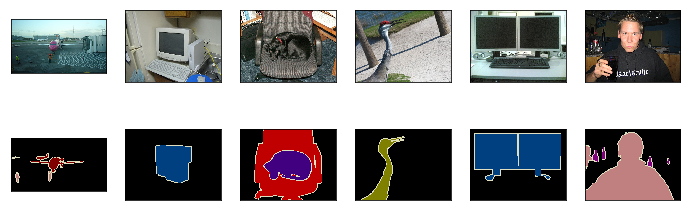

In [6]:
n = 6
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

Next, we list each RGB color value in the labels and the categories they label.

In [7]:
# This constant has been saved in the d2l package for future use
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# This constant has been saved in the d2l package for future use
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

After defining the two constants above, we can easily find the category index for each pixel in the labels.

In [15]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# This function has been saved in the d2l package for future use
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

For example, in the first example image, the category index for the front part of the airplane is 1 and the index for the background is 0.

In [16]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

### Data Preprocessing

In the preceding chapters, we scaled images to make them fit the input shape of the model. In semantic segmentation, this method would require us to re-map the predicted pixel categories back to the original-size input image. It would be very difficult to do this precisely, especially in segmented regions with different semantics. To avoid this problem, we crop the images to set dimensions and do not scale them. Specifically, we use the random cropping method used in image augmentation to crop the same region from input images and their labels.

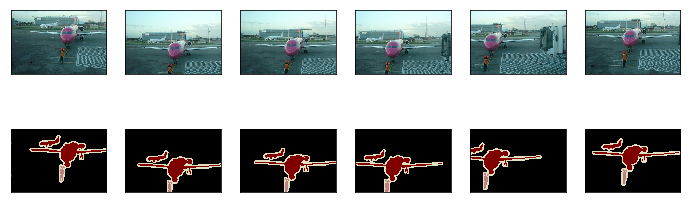

In [17]:
# This function has been saved in the d2l package for future use
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### Data Set Classes for Custom Semantic Segmentation

We use the inherited `Dataset` class provided by Gluon to customize the semantic segmentation data set class `VOCSegDataset`. By implementing the `__getitem__` function, we can arbitrarily access the input image with the index `idx` and the category indexes for each of its pixels from the data set. As some images in the data set may be smaller than the output dimensions specified for random cropping, we must remove these example by using a custom `filter` function. In addition, we define the `normalize_image` function to normalize each of the three RGB channels of the input images.

In [9]:
# This class has been saved in the d2l package for future use
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### Read the Data Set

Using the custom `VOCSegDataset` class, we create the training set and testing set instances. We assume the random cropping operation output images in the shape $320\times 480$. Below, we can see the number of examples retained in the training and testing sets.

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples
read 1078 examples


We set the batch size to 64 and define the iterators for the training and testing sets.

In [11]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',
                             num_workers=num_workers)

Print the shape of the first mini-batch. In contrast to image classification and object recognition, labels here are three-dimensional arrays.

In [12]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## Summary

* Semantic segmentation looks at how images can be segmented into regions with different semantic categories.
* In the semantic segmentation field, one important data set is Pascal VOC2012.
* Because the input images and labels in semantic segmentation have a one-to-one correspondence at the pixel level, we randomly crop them to a fixed size, rather than scaling them.

## Exercises

* Recall the content we covered in :numref:`chapter_image_augmentation`. Which of the image augmentation methods used in image classification would be hard to use in semantic segmentation?

##  Reference

[1] Pascal VOC2012 data set. http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2448)

![](../img/qr_semantic-segmentation-and-dataset.svg)